# Laboratoire 7
## Lidar, ICP et mapping

Ce laboratoire consiste à vous familiariser avec l'utilisation et le comportement de l'algorithme *Iterative Closest Point*. L'idée est d'aligner des scans lasers consécutifs de façon à construire une carte 2D de l'environnement. Notez qu'il ne s'agit pas ici de faire du SLAM, mais bien de simplement aligner des scans consécutifs sans faire de vérification ou ajustement par la suite.

![Le lidar Hokuyo](img/hokuyo.jpg)

Le scanner Hokuyo URG-04LX-UG01 possède un champ de vision horizontal de 270 degrés et une portée de 0.02 à 5.6 m. Placez les obstacles à l'intérieur de cette zone pendant la création de votre carte!

### Partie 1 - Afficher un scan

D'abord la poutine préliminaire habituelle.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib nbagg

import time
import numpy as np
import matplotlib.pyplot as plt

from robmob.icp import icp
from robmob.icp_orig import icp as icp_orig
from robmob.robot import Robot
from robmob.sensors import HokuyoSensor, FullOdomSensor

In [2]:
robot = Robot('192.168.0.108')
robot.connect()

In [3]:
hokuyo = HokuyoSensor()
robot.add_sensor(hokuyo)

La fonction `hokuyo_to_3d_homogeneous_matrix` accepte un scan du Hokuyo et le transforme en une matrice Nx4 de points 3D (en coordonnées homogènes). Elle fait simplement la conversion de coordonnées polaires à cartésiennes. Comme le Hokuyo est un scanneur 2D, la fonction fixe simplement la coordonnée en $z$ comme étant égale à 0.

In [4]:
def hokuyo_to_3d_homogeneous_matrix(hokuyo_data):
    ranges = np.array(hokuyo_data['ranges'])
    thetas = np.arange(hokuyo_data['angle_min'], hokuyo_data['angle_max']+hokuyo_data['angle_increment'], hokuyo_data['angle_increment'])
    xs = ranges * np.cos(thetas)
    ys = ranges * np.sin(thetas)
    
    pts = np.vstack((xs, ys, np.zeros(xs.shape), np.ones(xs.shape))).T
    
    # Remove the points that are at the origin.
    pts = pts[np.nonzero(np.logical_or(pts[:,0] != 0., pts[:,1] != 0.))]
    
    return pts

In [5]:
pointcloud = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())
pointcloud

array([[ -1.22829001e-08,  -2.80999988e-01,   0.00000000e+00,
          1.00000000e+00],
       [  1.73030723e-03,  -2.81994697e-01,   0.00000000e+00,
          1.00000000e+00],
       [  3.46056163e-03,  -2.81978771e-01,   0.00000000e+00,
          1.00000000e+00],
       ..., 
       [  5.30112555e-03,   2.87951195e-01,   0.00000000e+00,
          1.00000000e+00],
       [  3.49737601e-03,   2.84978537e-01,   0.00000000e+00,
          1.00000000e+00],
       [  1.77325811e-03,   2.88994564e-01,   0.00000000e+00,
          1.00000000e+00]])

La fonction `plot_point_clouds` accepte *une liste* de ces matrices et les trace sur un graphique. Le graphique est dans le repère de coordonnées du lidar, ce qui veux dire que les $x$ positifs pointent vers l'arrière du robot.

In [55]:
def plot_point_clouds(pcls):
    STYLES = ['r+', 'bx', 'g*', 'md', 'ys']
    
    for i, pcl in enumerate(pcls):
        plt.plot(pcl[:,0], pcl[:,1], STYLES[i], label='Nuage {}'.format(i))
        plt.plot([0.0], [0.0], 'ko')
        
    plt.axis('equal')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


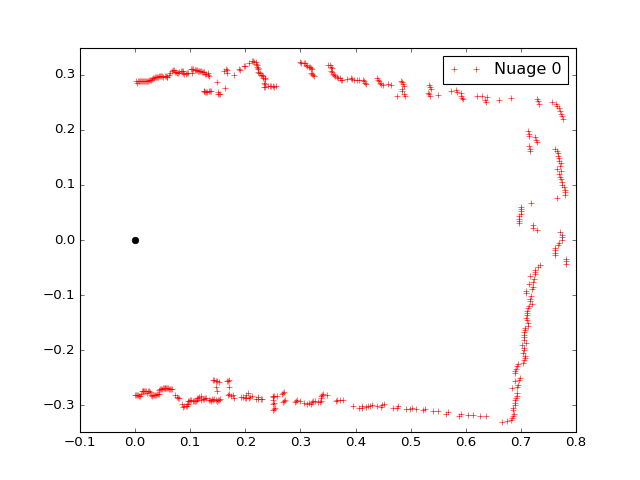

In [7]:
plot_point_clouds([pointcloud])

### Utiliser ICP

Nous avons une implémentation (un peu primitive) de l'algorithme ICP dans la librairie `robmob`. Pour l'utiliser, il faut appeler la fonction `icp`. Elle prend deux nuages de points en arguments et retourne une transformation homogène `H` qui exprime la position du premier nuage de point dans le repère de coordonnées du second. 

`icp` retourne aussi `err`, un vecteur qui donne la distance entre chaque paire de points associés. Ce vecteur est utile pour savoir si l'algorithme `icp` a bien convergé ou bien si le résultat laisse à désirer.

Pour tester l'algorithme, capturez un scan, déplacez le robot et capturez un autre scan.

> **PROTIP** Utilisez le fichier [Controller.ipynb](Controller.ipynb) pour déplacer le robot.

In [25]:
pcl1 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [26]:
pcl2 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [41]:
H, err = icp(pcl1, pcl2)

Mean distance between associated points: 0.05485765413620334
Mean distance between associated points: 0.048971473916513006
Mean distance between associated points: 0.042925628981419585
Mean distance between associated points: 0.036464538336763164
Mean distance between associated points: 0.02938756686707305
Mean distance between associated points: 0.024313705016412092
Mean distance between associated points: 0.020577476608937113
Mean distance between associated points: 0.0174338202931009
Mean distance between associated points: 0.014957180301702778
Mean distance between associated points: 0.012617685936201535
Mean distance between associated points: 0.011085893064251527
Mean distance between associated points: 0.009792358569998265
Mean distance between associated points: 0.00877816854648788
Mean distance between associated points: 0.008172155028840996


In [28]:
H

array([[ 0.99870769, -0.05082274,  0.        , -0.02967729],
       [ 0.05082274,  0.99870769,  0.        , -0.08921121],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

> **Attention** Au cours de ce laboratoire, nous travaillerons dans le référentiel du lidar. Comme le lidar pointe vers l'arrière du robot, c'est comme si le référentiel était inversé. Cela veut dire qu'une translation positive dans $H$ indique que le lidar a *avancé*. Par conéquent, une translation positive indique en fait que le robot a *reculé*.

Une bonne métrique pour évaluer la qualité d'un calage de nuages de points ICP est la distance moyenne entre les points couplés. Plus elle est basse,  plus les nuages de points sont compatibles entre eux.

In [29]:
print('La distance moyenne entre les points associés est de {} m'.format(np.average(err)))

La distance moyenne entre les points associés est de 0.04235301922402604 m


Avec la matrice H en main, il est possible de déplacer le nuage `pcl1` de sorte qu'il soit dans le repère de coordonnées de `pcl2`. Complétez la fonction `pcl_with_transformation_applied`. 

In [24]:
def pcl_with_transformation_applied(H, pcl):
    '''
    Apply an homogeneous transformation to a pointcloud.
    Input
        H: A 4x4 matrix describing an homogeneous geometric transformation.
        pcl: A Nx4 matrix containing the points to be displaced.
    Output
        transformed_pcl: A Nx4 matrix contaning the displaced points.
    '''
    return (H.dot(pcl.T)).T

L'appel suivant va tracer les deux nuages de points originaux, ainsi que le nuage de points déplacé.

> **PROTIP** Les graphiques de ce TP sont difficiles à lire. Souvenez-vous, l'objectif est de partir de `pcl1` et de venir le coller vers `pcl2`. Par exemple, dans le cas présent, Nuage 0 est le nuage d'origine et Nuage 2 sa version déplacée. Donc Nuage 2 devrait être identique à Nuage 0, mais collé sur Nuage 1.

<IPython.core.display.Javascript object>


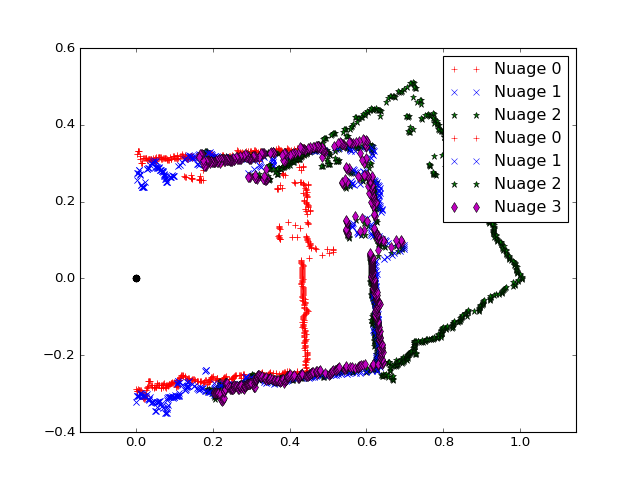

In [43]:
plot_point_clouds([pcl1, pcl2, pcl_with_transformation_applied(H, pcl1)])

> **Question** Est-ce que l'algorithme ICP est meilleur pour détecter les rotations ou les translations? Testez l'algorithme avec différentes rotations entre les deux scans, puis refaites l'expérience avec différentes translations entre les deux scans.

> **Question** Selon vos résultats à la question précédente, est-ce que l'ICP est capable de bien détecter de grandes transformations géométriques?

### Estimé initial

L'ICP est efficace pour trouver de petites transformations. Si on essaie de couvrir de trop grandes distances d'un scan à l'autre, l'ICP risque de tomber dans un minimum local. Pour cette raison c'est une bonne pratique de faire un estimé initial de la transformation $H$ que l'on cherche avant de lancer l'ICP. On pourrait se servir de l'odométrie, par exemple. La fonction suivante applique un estimé initial à un des nuages de points avant d'appeler ICP.

In [31]:
def icp_with_initial_estimate(pcl1, pcl2, estimate):
    '''
    Do ICP with an initial estimate.
    Input
        pcl1, pcl2: The point clouds to be matched. Nx4 matrices.
        estimate: A 4x4 homogeneous transformation that represents our estimate of the robot displacement.
    Output
        H: A 4x4 homogeneous transformation that represents the ICP-adjusted displacement between the two PCLs.
        err: A vector containing the distance between the matched points.
    '''
    pcl1_with_estimation = pcl_with_transformation_applied(estimate, pcl1)
    H, err = icp(pcl1_with_estimation, pcl2)
    
    return H.dot(estimate), err

In [33]:
pcl1 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

Avant de capturer le prochain scan, avancez le robot de 0.5 m dans la direction $x$ du lidar.

In [34]:
pcl2 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [44]:
# On estime que le robot a avancé de 0.5m vers l'avant *du lidar*.

dx = 0.5 # Déplacement en x
dy = 0.0 # Déplacement en y
rotation = 0.5 # En radians
estimate = np.array([[np.cos(rotation), -np.sin(rotation), 0.0, dx],
                     [np.sin(rotation), np.cos(rotation), 0.0, dy],
                     [0.0, 0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0, 1.0]])

H, err = icp_with_initial_estimate(pcl1, pcl2, estimate)
print(H)
print('La distance moyenne entre les points associés est de {} m'.format(np.average(err)))

Mean distance between associated points: 0.14264376993520997
Mean distance between associated points: 0.07161931570928703
Mean distance between associated points: 0.05206037015178583
Mean distance between associated points: 0.04346842110369774
Mean distance between associated points: 0.03899745536116909
Mean distance between associated points: 0.036604925012940825
Mean distance between associated points: 0.03516343166396372
Mean distance between associated points: 0.0335181824531333
Mean distance between associated points: 0.03150203082229364
Mean distance between associated points: 0.029576854432300584
Mean distance between associated points: 0.0280461362008227
Mean distance between associated points: 0.02667651311518682
Mean distance between associated points: 0.025333350710316564
Mean distance between associated points: 0.023580275053278695
Mean distance between associated points: 0.021784821796869094
Mean distance between associated points: 0.020123539820617077
Mean distance betwee

Une fois de plus, ce graphique est difficile à lire. L'objectif est de coller Nuage 0 sur Nuage 1. Nuage 2 est une version de Nuage 1 qui est déplacé selon notre estimé initial. Nuage 2 n'a donc jamais passé par l'ICP. Nuage 3 est une version de nuage 0 qui a été déplacée selon le résultat de l'ICP.

<IPython.core.display.Javascript object>


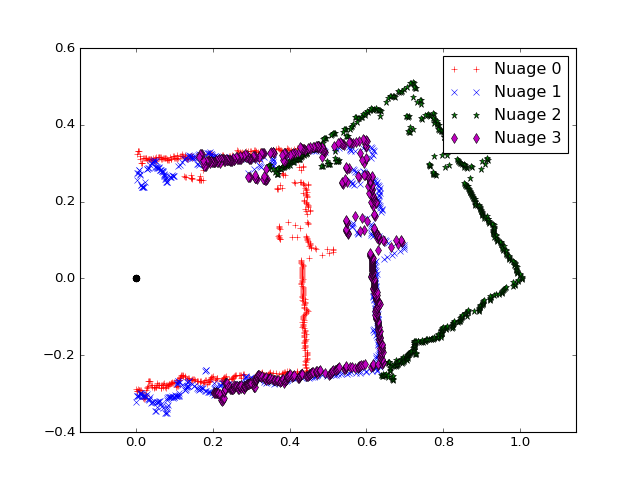

In [46]:
pcl1_with_estimate = pcl_with_transformation_applied(estimate, pcl1)
pcl1_after_icp = pcl_with_transformation_applied(H, pcl1)

plot_point_clouds([pcl1, pcl2, pcl1_with_estimate, pcl1_after_icp])

> **Question** Est-ce que d'ajouter un estimé initial a aidé l'algorithme ICP à mieux converger dans le cas présent? Est-ce que l'ICP est capable de détecter correctement de plus grandes transformations géométriques avec un estimé initial?

> **Question** Est-ce que l'ICP est capable de se rétablir si vous sabotez l'estimé initial? À quelle gradeur de sabotage est-ce que l'ICP est capable de résister?

### Estimé initial grâce à l'odométrie

Il serait plus astucieux de se servir de l'odométrie pour faire un estimé initial, plutôt que de demander à un humain de le faire. La fonction `homogeneous_transformation_of_two_poses` trouve la matrice 4x4 de transformation homogène qui passe d'une position à l'autre.

In [47]:
def homogeneous_transformation_of_two_poses(pose1, pose2):
    dx = pose2[0] - pose1[0]
    dy = pose2[1] - pose1[1]
    dtheta = pose2[2] - pose1[2]
    
    return np.array([[np.cos(dtheta), -1*np.sin(dtheta), 0.0, dx],
                       [np.sin(dtheta), np.cos(dtheta), 0.0, dy],
                       [0.0, 0.0, 1.0, 0.0],
                       [0.0, 0.0, 0.0, 1.0]])

Le bloc suivant nous abonne aux données d'odométrie. Ensuite on peut collecter l'estimé d'odométrie en même temps que l'on connecte des scans lidar.

In [48]:
odom_sensor = FullOdomSensor()
robot.add_sensor(odom_sensor)

In [49]:
pose1 = odom_sensor.peek_data()
pcl1 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [50]:
pose2 = odom_sensor.peek_data()
pcl2 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [51]:
odom_estimate = homogeneous_transformation_of_two_poses(pose1, pose2)
odom_estimate

array([[  8.11165901e-01,   5.84816109e-01,   0.00000000e+00,
          7.19787988e-05],
       [ -5.84816109e-01,   8.11165901e-01,   0.00000000e+00,
          1.39095027e-03],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [52]:
# ICP sans estimé d'odométrie.
H_without_estimate, err = icp(pcl1, pcl2)
H_without_estimate

Mean distance between associated points: 0.10963648356379187
Mean distance between associated points: 0.06553982682870209
Mean distance between associated points: 0.056232344266867615
Mean distance between associated points: 0.05099619011998824
Mean distance between associated points: 0.04744210559761353
Mean distance between associated points: 0.04516730578712506
Mean distance between associated points: 0.0427103052122843
Mean distance between associated points: 0.04051471558906192
Mean distance between associated points: 0.038133660114555726
Mean distance between associated points: 0.036045948573616225
Mean distance between associated points: 0.03479074945068105
Mean distance between associated points: 0.03405271190200762


array([[ 0.95705335,  0.28991185,  0.        , -0.01630806],
       [-0.28991185,  0.95705335,  0.        , -0.08783954],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [53]:
# ICP avec estimé d'odométrie.
H, err = icp_with_initial_estimate(pcl1, pcl2, odom_estimate)
H

Mean distance between associated points: 0.03228245490531447
Mean distance between associated points: 0.027190161634896483
Mean distance between associated points: 0.027281431360903587


array([[ 0.85691309,  0.51546091,  0.        ,  0.0169633 ],
       [-0.51546091,  0.85691309,  0.        , -0.04460905],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Le graphique suivant est encore plus difficile à lire, donc allez-y pas à pas. Nuage 0 est le nuage original, et Nuage 1 notre objectif. Nuage 2 est une version de nuage 0 déplacée selon notre estimé d'odométrie. Nuage 3 est une version de Nuage 0 déplacée selon l'icp avec estimé initial. Nuage 4 est une version de nuage 0 déplacé selon l'icp sans estimé initial.

<IPython.core.display.Javascript object>


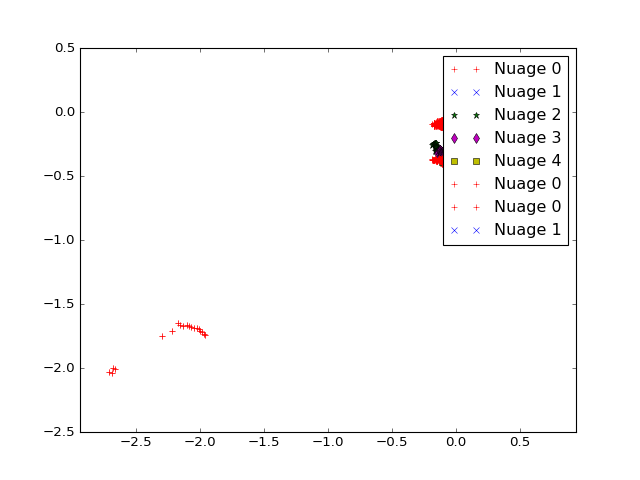

In [56]:
pcl1_with_estimate = pcl_with_transformation_applied(odom_estimate, pcl1)
pcl1_after_icp = pcl_with_transformation_applied(H, pcl1)
pcl1_after_lesser_icp = pcl_with_transformation_applied(H_without_estimate, pcl1)

plot_point_clouds([pcl1, pcl2, pcl1_with_estimate, pcl1_after_icp, pcl1_after_lesser_icp])

### Construction d'une carte

Pour construire une carte de l'environnement avec le lidar, il faut intégrer tous les outils utilisés jusqu'à présent. La boucle suivante additionne les transformations successives détectées par l'ICP. On peut donc suivre le déplacement du robot dans l'environnement. 

Malheureusement l'algorithme d'ICP dont on dispose ne permet pas de faire l'ICP d'un scan lidar contre toute la carte construite. Il faut donc additionner les transformations du premier scan vers le deuxième, du deuxième vers le troisième, etc. La conséquence de cela est qu'un ICP de mauvaise qualité va affecter toutes les positions estimées successives. C'est un peu comme faire de la navigation à l'aveugle avec l'odométrie.

In [65]:
# Le premier scan va servir de base à notre carte. On va y ajouter les scans suivants.
built_map = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())
previous_reading = built_map.copy()

sum_of_H = np.eye(4)
lidar_positions = np.array([[0.0, 0.0, 0.0, 1.0]]) # On considère que la position initiale du lidar est l'origine.
clouds = []
clouds.append(previous_reading)

for i in range(30):
    # Prendre une lecture du lidar.
    reading = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())
    clouds.append(reading)
    
    # Exécuter ICP
    H, err = icp(reading, previous_reading)
    print('La translation détectée par l\'ICP est de {:0.4f} m'.format(np.linalg.norm(H[0:1, 3])))
    
    # Ajouter la transformation trouvée à notre somme de transformations.
    sum_of_H = H.dot(sum_of_H)
    
    # Mettre à jour la position du robot.
    previous_position = lidar_positions[-1,:]
    new_position = sum_of_H.dot(np.array([0.0, 0.0, 0.0, 1.0]).T).T
    lidar_positions = np.vstack((lidar_positions, new_position))
    
    # Ajouter le scan déplacé à la carte
    displaced_reading = pcl_with_transformation_applied(sum_of_H, reading)
    built_map = np.concatenate((built_map, displaced_reading), axis=0)
    
    previous_reading = reading
    
    time.sleep(0.15)
    
plot_point_clouds([built_map])

Mean distance between associated points: 0.0
La translation détectée par l'ICP est de 0.0000 m
Mean distance between associated points: 0.003901864434509807
Mean distance between associated points: 0.0039059845495704763
La translation détectée par l'ICP est de 0.0002 m
Mean distance between associated points: 0.003615650027252759
Mean distance between associated points: 0.003609919971825871
La translation détectée par l'ICP est de 0.0004 m
Mean distance between associated points: 0.0036159426329038747
Mean distance between associated points: 0.0036169096617015193
La translation détectée par l'ICP est de 0.0002 m
Mean distance between associated points: 0.0038096647462488907
Mean distance between associated points: 0.0038215572933054023
La translation détectée par l'ICP est de 0.0001 m
Mean distance between associated points: 0.003971364545177935
Mean distance between associated points: 0.0039497995892147225
La translation détectée par l'ICP est de 0.0006 m
Mean distance between associa

<IPython.core.display.Javascript object>


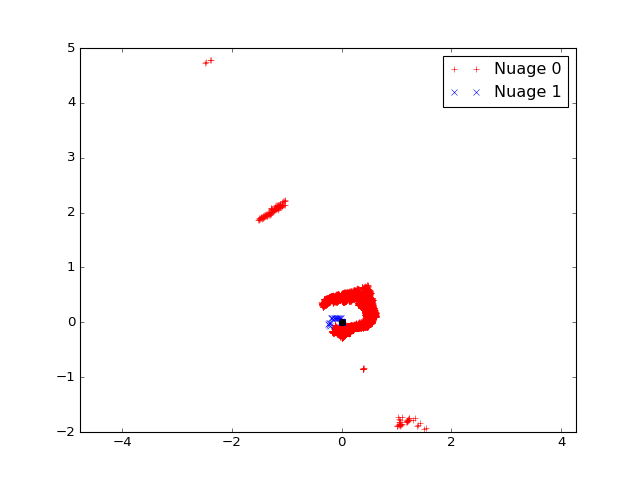

In [66]:
plot_point_clouds([built_map, lidar_positions])

In [ ]:
sum_of_H